## https://lifelines.readthedocs.io/en/latest/Quickstart.html#getting-data-in-the-right-format

In [1]:
import sys
sys.executable

In [2]:
import pandas as pd
import lifelines
import pickle

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
gleason_sum = pickle.load(open('../prad_gleason_sum.pkl', 'rb'))
positive_lymphnodes = pickle.load(open('../prad_positive_lymphnodes.pkl', 'rb'))
at_least_one_lymphnode = {k: x > 0 for k, x in positive_lymphnodes.items()}

408


(array([328.,  45.,  13.,   0.,  11.,   2.,   2.,   0.,   3.,   1.,   1.,
          0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   1.]),
 array([ 0.  ,  0.75,  1.5 ,  2.25,  3.  ,  3.75,  4.5 ,  5.25,  6.  ,
         6.75,  7.5 ,  8.25,  9.  ,  9.75, 10.5 , 11.25, 12.  , 12.75,
        13.5 , 14.25, 15.  ]),
 <a list of 20 Patch objects>)

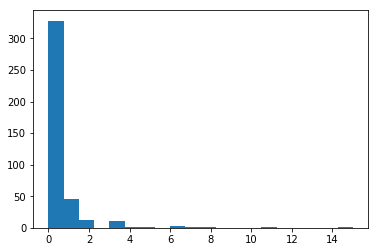

In [4]:
plymphs = [x for k,x in positive_lymphnodes.items()]
print(len(plymphs))
plt.hist(plymphs, bins=20)

499


(array([ 45.,   0., 249.,   0.,   0.,  64.,   0., 137.,   0.,   4.]),
 array([ 6. ,  6.4,  6.8,  7.2,  7.6,  8. ,  8.4,  8.8,  9.2,  9.6, 10. ]),
 <a list of 10 Patch objects>)

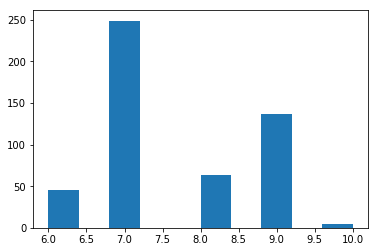

In [5]:
grades = [x for k,x in gleason_sum.items()]
print(len(grades))
plt.hist(grades)

              GleasonSum  LymphNodes
TCGA-CH-5753           9           3
TCGA-CH-5763           7           0
TCGA-CH-5764           7           0
TCGA-CH-5772           9           0
TCGA-CH-5790           7           0
(408, 2)


/home/ing/miniconda3/envs/milk/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


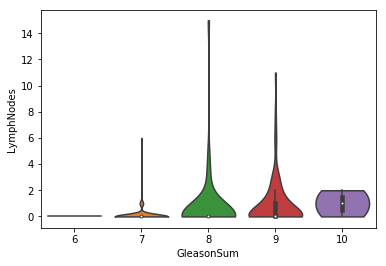

In [6]:
keys = [k for k in positive_lymphnodes]
nlymphs = [positive_lymphnodes[k] for k in positive_lymphnodes]
df_ln = pd.DataFrame({'LymphNodes': nlymphs}, index=keys)

keys = [k for k in gleason_sum]
grades = [gleason_sum[k] for k in gleason_sum]
df_gs = pd.DataFrame({'GleasonSum': grades}, index=keys)

df = pd.concat([df_gs, df_ln], join='inner', axis=1)
print(df.head())
print(df.shape)

sns.violinplot(x='GleasonSum', y='LymphNodes', data=df, cut=0, width=0.8, scale='width')

In [7]:
import os
import numpy as np
import glob
predicted_sets = glob.glob('../tcga-prad-avg/*_ypred.npy')
print(len(predicted_sets))
ypred = {}
for pth in predicted_sets:
    c = os.path.basename(pth)[:12]
    y = np.squeeze(np.argmax(np.load(pth), -1))
    ypred[c] = y

255


In [8]:
# translate the pickled data:
days_to_biochem_recurr = pickle.load(open('../prad_days_to_biochemical_recurrence.pkl', 'rb'))
print(len(days_to_biochem_recurr.keys()))

427


158
26


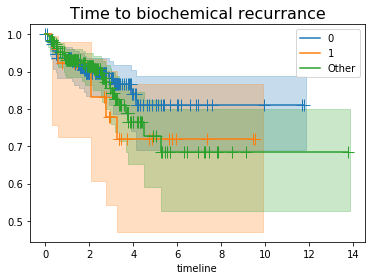

In [22]:
T_0, E_0 = [], []
T_1, E_1 = [], []
T, E = [], []
for k, v in days_to_biochem_recurr.items():
#     print(k, gleason_sum[k])
    if gleason_sum[k] < 7:
        continue
        
    if k in ypred.keys():
        if ypred[k] == 0:
            T_0.append(v[0] / 365)
            E_0.append(v[1])
        else:
            T_1.append(v[0] / 365)
            E_1.append(v[1])
    else:
        T.append(v[0] / 365)
        E.append(v[1])
            
print(len(T_0))
print(len(T_1))
kmf = lifelines.KaplanMeierFitter()
kmf.fit(T_0, E_0, label='0')
ax = kmf.plot(show_censors=True)
kmf.fit(T_1, E_1, label='1')
ax = kmf.plot(show_censors=True, ax=ax)
kmf.fit(T, E, label='Other')
ax = kmf.plot(show_censors=True, ax=ax)
ax.set_title('Time to biochemical recurrance', fontsize=16)
plt.savefig('prad_km_time_to_biochem_recurrance.png', bbox_inches='tight')
# plt.legend(fontsize=14)

In [23]:
result = lifelines.statistics.logrank_test(T_0, T_1, event_observed_A=E_0, event_observed_B=E_1)
result.print_summary()
print(result.p_value)
print(result.test_statistic)
print('------------------------------------------------------------')

result = lifelines.statistics.survival_difference_at_fixed_point_in_time_test(5, durations_A=T_0, durations_B=T_1,
    event_observed_A=E_0, event_observed_B=E_1)
result.print_summary()

<lifelines.StatisticalResult>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1

---
test_statistic    p  -log2(p)
          1.10 0.30      1.76
0.29504835460832407
1.0964415913796666
------------------------------------------------------------
<lifelines.StatisticalResult>
 null_distribution = chi squared
degrees_of_freedom = 1
     point_in_time = 5

---
test_statistic    p  -log2(p)
          0.76 0.38      1.39


In [11]:
days_to_new_tumor = pickle.load(open('../prad_days_to_new_tumor_event.pkl', 'rb'))

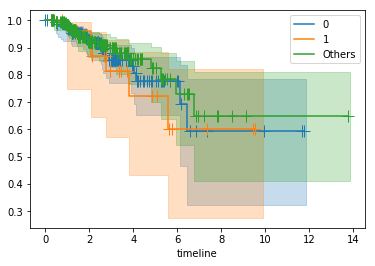

In [24]:
T_0, E_0 = [], []
T_1, E_1 = [], []
T, E = [], []
for k, v in days_to_new_tumor.items():
    if gleason_sum[k] < 7:
        continue
        
    if k in ypred.keys():
        if ypred[k] == 0:
            T_0.append(v[0] / 365)
            E_0.append(v[1])
        else:
            T_1.append(v[0] / 365)
            E_1.append(v[1])
    else:
        T.append(v[0] / 365)
        E.append(v[1])
            
kmf = lifelines.KaplanMeierFitter()
kmf.fit(T_0, E_0, label='0')
ax = kmf.plot(show_censors=True)
kmf.fit(T_1, E_1, label='1')
ax = kmf.plot(show_censors=True, ax=ax)
kmf.fit(T, E, label='Others')
ax = kmf.plot(show_censors=True, ax=ax)

In [25]:
result = lifelines.statistics.logrank_test(T_0, T_1, event_observed_A=E_0, event_observed_B=E_1)
result.print_summary()
print(result.p_value)
print(result.test_statistic)
print('------------------------------------------------------------')

result = lifelines.statistics.survival_difference_at_fixed_point_in_time_test(5, durations_A=T_0, durations_B=T_1,
    event_observed_A=E_0, event_observed_B=E_1)
result.print_summary()

<lifelines.StatisticalResult>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1

---
test_statistic    p  -log2(p)
          0.25 0.62      0.69
0.6193394684920392
0.24679703467094696
------------------------------------------------------------
<lifelines.StatisticalResult>
 null_distribution = chi squared
degrees_of_freedom = 1
     point_in_time = 5

---
test_statistic    p  -log2(p)
          0.21 0.64      0.64


In [14]:
gg = {0: [0,0,0,0,0], 1: [0,0,0,0,0]}
for k, y in ypred.items():
    try:
        g = gleason_sum[k]-6
        gg[int(y)][g] +=1
    except:
        print(k,y)

TCGA-HC-7741 1


<BarContainer object of 2 artists>

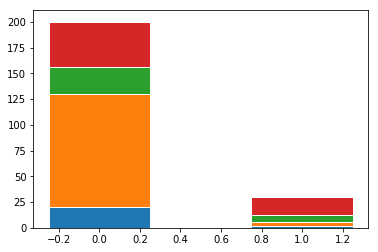

In [15]:
barWidth = 0.5
gs6 = [gg[0][0], gg[1][0]]
gs7 = [gg[0][1], gg[1][1]]
gs8 = [gg[0][2], gg[1][2]]
gs9 = [gg[0][3], gg[1][3]]
gs10 = [gg[0][4], gg[1][4]]

r = [0,1]

plt.bar(r, gs6, edgecolor='white', width=barWidth)
plt.bar(r, gs7, bottom=gs6, edgecolor='white', width=barWidth)
plt.bar(r, gs8,  bottom=np.sum([gs6, gs7], axis=0), edgecolor='white', width=barWidth)
plt.bar(r, gs9,  bottom=np.sum([gs6, gs7, gs8], axis=0), edgecolor='white', width=barWidth)
plt.bar(r, gs10, bottom=np.sum([gs6, gs7, gs8, gs9], axis=0), edgecolor='white', width=barWidth)


In [16]:
ypred_vect = []
pos_ln = []
for k in ypred:
    try:
        if gleason_sum[k] < 7:
            continue
        pos_ln.append(at_least_one_lymphnode[k])
        ypred_vect.append(ypred[k])
    except:
        continue
        
ypred_vect = np.array(ypred_vect).astype(np.uint8)
pos_ln = np.array(pos_ln).astype(np.uint8)
print('ypred\n', ypred_vect)
print('at least one positive LN:\n', pos_ln)

print((ypred_vect == pos_ln).mean())

ypred
 [1 1 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0
 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
at least one positive LN:
 [1 0 0 0 1 1 1 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0
 0 0 0 1 1 0 1 1 1 0 1 1 0 0 1 0 1 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0 1 0 0
 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 1 0 1 1
 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0]
0.7584269662921348


44
212


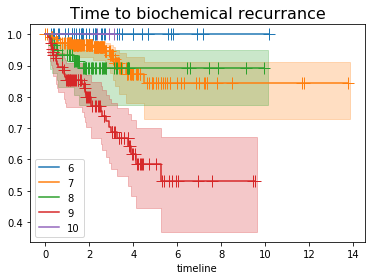

In [17]:
T_0, E_0 = [], []
T_1, E_1 = [], []
T_2, E_2 = [], []
T_3, E_3 = [], []
T_4, E_4 = [], []
for k, v in days_to_biochem_recurr.items():
#     print(k, gleason_sum[k])
#     if gleason_sum[k] < 8:
#         continue
        
    if k in gleason_sum.keys():
        if gleason_sum[k] == 6:
            T_0.append(v[0] / 365)
            E_0.append(v[1])
        elif gleason_sum[k] == 7:
            T_1.append(v[0] / 365)
            E_1.append(v[1])
        elif gleason_sum[k] == 8:
            T_2.append(v[0] / 365)
            E_2.append(v[1])
        elif gleason_sum[k] == 9:
            T_3.append(v[0] / 365)
            E_3.append(v[1])
        elif gleason_sum[k] == 10:
            T_4.append(v[0] / 365)
            E_4.append(v[1])
    else:
        print(k)
            
print(len(T_0))
print(len(T_1))
kmf = lifelines.KaplanMeierFitter()
kmf.fit(T_0, E_0, label='6')
ax = kmf.plot(show_censors=True)

kmf.fit(T_1, E_1, label='7')
ax = kmf.plot(show_censors=True, ax=ax)

kmf.fit(T_2, E_2, label='8')
ax = kmf.plot(show_censors=True, ax=ax)

kmf.fit(T_3, E_3, label='9')
ax = kmf.plot(show_censors=True, ax=ax)

kmf.fit(T_4, E_4, label='10')
ax = kmf.plot(show_censors=True, ax=ax)

ax.set_title('Time to biochemical recurrance', fontsize=16)
plt.savefig('prad_km_time_to_biochem_recurrance.png', bbox_inches='tight')
# plt.legend(fontsize=14)